###                                                HW9
1. Download the new test2_new.txt data which contains the ground-truth of the track ID recommendations. 

2. Use the userID in test2_new.txt to fetch the related rating scores in the training data for the same users. 

3. For the fetched rating score matrix, use the "1" and "0" recommendations in test2 to training your classifier.  You need to use 

from pyspark.ml.classification import ******
You need to try 4 different classifiers in the pyspark.ml library as shown in the lecture notes to train your models.  

4. Then apply the trained models to what you fetched rating scores from the final project test data and make predictions.  Submit your new results at Kaggle. 

#### 1.build the LogisticRegression model

In [ ]:
#pip install pyspark

In [ ]:
#conda install -c cyclus java-jdk

In [ ]:
#pip install py4j

In [29]:
#load pySpark modules 

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F
spark = SparkSession.builder.getOrCreate()
sc=spark.sparkContext

In [2]:
#load training data file into pySpark dataFrame format

training = spark.read.csv("test_new.csv", header = False)
#rename training dataFrame column names

training = training.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "itemID").withColumnRenamed("_c2", "rating")
training = training.withColumn('TrackID', F.concat(F.col('userID'),F.lit('_'), F.col('itemID'))).select('TrackID','rating')
training.show(5)


+-------------+------+
|      TrackID|rating|
+-------------+------+
| 200031_30877|     1|
|  200031_8244|     1|
|200031_130183|     0|
|200031_198762|     0|
| 200031_34503|     1|
+-------------+------+
only showing top 5 rows



In [3]:
score = spark.read.csv("score.csv", header = False)
#rename training dataFrame column names

score = score.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "itemID").withColumnRenamed("_c2", "score1").withColumnRenamed("_c3", "score2")

score.show(5)

+------+------+------+------+
|userID|itemID|score1|score2|
+------+------+------+------+
|199810|208019|   0.0|   0.0|
|199810| 74139|   0.0|   0.0|
|199810|  9903|   0.0|   0.0|
|199810|242681|   0.0|   0.0|
|199810| 18515|   0.0|  70.0|
+------+------+------+------+
only showing top 5 rows



In [4]:

weighted_score = score.withColumn("weighted_score", F.round(0.8*score.score1+0.2*score.score2))
weighted_score = weighted_score.withColumn('TrackID', F.concat(F.col('userID'),F.lit('_'), F.col('itemID'))).select('TrackID','weighted_score')
weighted_score.show(5)

+-------------+--------------+
|      TrackID|weighted_score|
+-------------+--------------+
|199810_208019|           0.0|
| 199810_74139|           0.0|
|  199810_9903|           0.0|
|199810_242681|           0.0|
| 199810_18515|          14.0|
+-------------+--------------+
only showing top 5 rows



In [5]:
weighted_score.printSchema()

root
 |-- TrackID: string (nullable = true)
 |-- weighted_score: double (nullable = true)



In [7]:
df = training.join(weighted_score,training.TrackID == weighted_score.TrackID,"inner").drop(weighted_score.TrackID).select('TrackID','weighted_score','rating')
df.show(6)

+-------------+--------------+------+
|      TrackID|weighted_score|rating|
+-------------+--------------+------+
| 200031_30877|          82.0|     1|
|  200031_8244|          72.0|     1|
|200031_130183|           0.0|     0|
|200031_198762|           0.0|     0|
| 200031_34503|          82.0|     1|
|200031_227283|          18.0|     0|
+-------------+--------------+------+
only showing top 6 rows



In [8]:
df.printSchema()

root
 |-- TrackID: string (nullable = true)
 |-- weighted_score: double (nullable = true)
 |-- rating: string (nullable = true)



In [9]:
from pyspark.sql.types import IntegerType

df = df.withColumn("weighted_score", df["weighted_score"].cast('float'))

df.show(3)

+-------------+--------------+------+
|      TrackID|weighted_score|rating|
+-------------+--------------+------+
| 200031_30877|          82.0|     1|
|  200031_8244|          72.0|     1|
|200031_130183|           0.0|     0|
+-------------+--------------+------+
only showing top 3 rows



In [10]:
df.printSchema()

root
 |-- TrackID: string (nullable = true)
 |-- weighted_score: float (nullable = true)
 |-- rating: string (nullable = true)



### build the model

In [15]:

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorIndexer,VectorAssembler

In [61]:
# Configure an ML pipeline
label_stringIdx = StringIndexer(inputCol = 'rating', outputCol = 'label')
numericCols = ['weighted_score']
numVect = VectorAssembler(inputCols = ['weighted_score'], outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)

#lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
pipeline = Pipeline(stages=[numVect, label_stringIdx, lr])
# Split the data into training and test sets (30% held out for testing)
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
# Fit the pipeline to training documents.
lrmodel = pipeline.fit(train)


In [60]:
print("Coefficients: \n" + str(lrmodel.stages[-1].coefficientMatrix))
print("Intercept: " + str(lrmodel.stages[-1].interceptVector))

Coefficients: 
DenseMatrix([[0.10817485]])

Intercept: [-1.2695859821629902]


### Evaluate our Logistic Regression model.

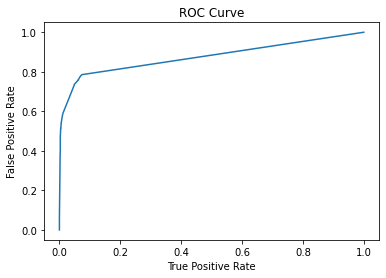

Training set areaUnderROC: 0.8759553097602996


In [51]:
trainingSummary = lrmodel.stages[-1].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/Users/bding/Documents/Anaconda/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


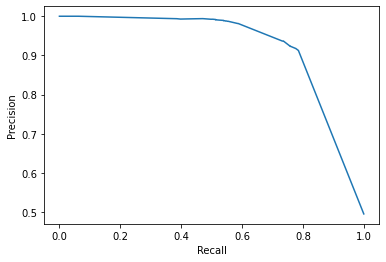

In [58]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [56]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8492366412213741
FPR: 0.15247538375008457
TPR: 0.8492366412213741
F-measure: 0.8479225871194789
Precision: 0.8602466789869632
Recall: 0.8492366412213741


### Make predictions on the test set

In [62]:
predictions = lrmodel.transform(test)
predictions.show(12)

+-------------+--------------+------+--------+-----+--------------------+--------------------+----------+
|      TrackID|weighted_score|rating|features|label|       rawPrediction|         probability|prediction|
+-------------+--------------+------+--------+-----+--------------------+--------------------+----------+
|200031_130183|           0.0|     0|   [0.0]|  0.0|[1.26958598216299...|[0.78067186664810...|       0.0|
| 200032_18681|          90.0|     1|  [90.0]|  1.0|[-8.4661502690590...|[2.10429322666623...|       1.0|
| 200032_64167|          90.0|     1|  [90.0]|  1.0|[-8.4661502690590...|[2.10429322666623...|       1.0|
|200055_134398|          18.0|     1|  [18.0]|  1.0|[-0.6775612680814...|[0.33680581945586...|       1.0|
| 200055_56695|          90.0|     1|  [90.0]|  1.0|[-8.4661502690590...|[2.10429322666623...|       1.0|
|200065_179571|           0.0|     0|   [0.0]|  0.0|[1.26958598216299...|[0.78067186664810...|       0.0|
| 200065_26875|          90.0|     1|  [90.0]|

In [28]:
#Evaluating prediction results

tp = float(predictions.filter("prediction == 1.0 AND rating == 1").count())
fp = float(predictions.filter("prediction == 1.0 AND rating == 0").count())
tn = float(predictions.filter("prediction == 0.0 AND rating == 0").count())
fn = float(predictions.filter("prediction == 0.0 AND rating == 1").count())
pr = tp / (tp + fp)
re = tp / (tp + fn)
metrics = spark.createDataFrame([
 ("TP", tp),
 ("FP", fp),
 ("TN", tn),
 ("FN", fn),
 ("Precision", pr),
 ("Recall", re),
 ("F1", 2*pr*re/(re+pr))],["metric", "value"])
metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|             659.0|
|       FP|              44.0|
|       TN|             793.0|
|       FN|             218.0|
|Precision|0.9374110953058321|
|   Recall|0.7514253135689852|
|       F1|0.8341772151898734|
+---------+------------------+



In [44]:
#Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8705093256717195


In [63]:
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.129491


### Make predictions on the rating scores data

In [54]:
#Use the model to pedict the whole test data
prediction_all = lrmodel.transform(weighted_score)
prediction_all.show(12)

+-------------+--------------+--------+--------------------+--------------------+----------+
|      TrackID|weighted_score|features|       rawPrediction|         probability|prediction|
+-------------+--------------+--------+--------------------+--------------------+----------+
|199810_208019|           0.0|   [0.0]|[1.26958598216299...|[0.78067186664810...|       0.0|
| 199810_74139|           0.0|   [0.0]|[1.26958598216299...|[0.78067186664810...|       0.0|
|  199810_9903|           0.0|   [0.0]|[1.26958598216299...|[0.78067186664810...|       0.0|
|199810_242681|           0.0|   [0.0]|[1.26958598216299...|[0.78067186664810...|       0.0|
| 199810_18515|          14.0|  [14.0]|[-0.2448618791382...|[0.43908856714809...|       1.0|
|199810_105760|          18.0|  [18.0]|[-0.6775612680814...|[0.33680581945586...|       1.0|
|199812_276940|           0.0|   [0.0]|[1.26958598216299...|[0.78067186664810...|       0.0|
|199812_142408|         100.0| [100.0]|[-9.5478987414170...|[7.1345942

22/04/29 22:00:12 WARN StringIndexerModel: Input column rating does not exist during transformation. Skip StringIndexerModel for this column.


In [39]:
#select "TrackID","Predictor"
prediction_All = prediction_all.withColumnRenamed("prediction", "Predictor").select("TrackID","Predictor")

In [40]:
prediction_All.show(5)

+-------------+---------+
|      TrackID|Predictor|
+-------------+---------+
|199810_208019|      0.0|
| 199810_74139|      0.0|
|  199810_9903|      0.0|
|199810_242681|      0.0|
| 199810_18515|      1.0|
+-------------+---------+
only showing top 5 rows



In [41]:
prediction_All.count()

120000

In [36]:
#save the results to csv file
prediction_All.toPandas().to_csv('prediction_lr.csv')